PassengerId & Ticket - don't add value to the prediction since they are unique identification values

Pclass - important ordinal attribute

Fare - important ordinal attribute

Name - we could infer new attributes from 'Mr', 'Mrs', 'Miss', 'Master' (see other values)

Sex - nominal

Age - quantitative

SibSp - # of siblings/spouse

Parch - # of parents/childrens

Cabin - cabin type: to exclude since ~80% empty

Embarked - port of embarcation

Survived - to predict

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def summary_missing_data(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['# of Missing', 'Percent'])
    return missing_data

#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)


In [3]:
raw = pd.read_csv('./data/train.csv')
rawt = pd.read_csv('./data/test.csv')

In [4]:
raw.shape, rawt.shape

((891, 12), (418, 11))

In [5]:
raw.shape[0] + rawt.shape[0]

1309

In [6]:
brk = raw.shape[0]
data_cleaner = pd.concat([raw.copy(), rawt.copy()], ignore_index=True)
data_cleaner.shape

(1309, 12)

In [7]:
data_cleaner.iloc[brk-2:brk+2, :]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
889,26.0,C148,C,30.0000,"Behr, Mr. Karl Howell",0,890,1,male,0,1.0,111369
890,32.0,NaN,Q,7.7500,"Dooley, Mr. Patrick",0,891,3,male,0,0.0,370376
891,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911
892,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,NaN,363272


# m

In [8]:
summary_missing_data(data_cleaner.drop(columns=['Survived'])).head(6)

,# of Missing,Percent
Cabin,1014,0.774637
Age,263,0.200917
Embarked,2,0.001528
Fare,1,0.000764
Ticket,0,0.000000
SibSp,0,0.000000


# Attributes that don't add value to our predictor
- **PassengerId** and **Ticket** don't add value to the prediction since they are unique identification values
- **Cabin** to exclude since ~80% empty

In [9]:
data_cleaner = data_cleaner.drop(columns=['Cabin', 'Ticket'])

# Missing values

- How to deal with **Age**?
    - Fill mode? median by groups?
    
    
- Who are the ones with no **Embarked** and **Fare**?
    - Decide what to do
    - Fill the **Embarked** and **Fare** type of other similar persons (by age? parch? pclass?)

# Fill NAs

In [10]:
fillers = {
    'Age': raw['Age'].mode()[0],
    'Embarked': raw['Embarked'].mode()[0],
    'Fare': raw['Fare'].mode()[0]
}
data_cleaner = data_cleaner.fillna(fillers)
summary_missing_data( data_cleaner.drop(columns=['Survived']) ).head()

,# of Missing,Percent
SibSp,0,0.0
Sex,0,0.0
Pclass,0,0.0
PassengerId,0,0.0
Parch,0,0.0


# Title

- Identify from the **Name** meaningful socio-economic status as 'Mr', 'Mrs', 'Dr', 'Master', etc appears. Do OneHot encoder on them, then delete column Name

In [11]:
u_titles = []
for n in data_cleaner['Name']:
    s = n.split(',')
    status = s[1].split('.')
    u_titles.append(status[0].strip())
titles = list(set(u_titles))
pd.Series(u_titles).value_counts()
# titles

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Sir               1
Lady              1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Don               1
Mme               1
dtype: int64

In [12]:
titles = ['Mr', 'Miss', 'Mrs', 'Master']

In [13]:
titles_encoded = []
for a_title in titles:
    titles_encoded.append(pd.DataFrame([ 1 if n.find(a_title+'.') >= 0 else 0 for n in data_cleaner['Name'] ], columns=[a_title]))

# Family Size

- Combine **SibSp** and **Parch** into one feature **FamilySize**

In [14]:
data_cleaner.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0


In [15]:
data_cleaner['FamilySize'] = data_cleaner['SibSp'] + data_cleaner['Parch']

# Get dummies

In [16]:
datasetdummy = pd.concat([data_cleaner, *titles_encoded], axis=1)
datasetdummy = datasetdummy.drop(columns=['Name'])
datasetdummy.shape

(1309, 14)

In [17]:
datasetdummy = pd.get_dummies(datasetdummy, columns=['Embarked', 'Sex'])
datasetdummy = datasetdummy.drop(columns=['Sex_male'])
datasetdummy = datasetdummy.rename(columns={'Sex_female':'Sex_code'})

In [18]:
datasetdummy.head(5)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,FamilySize,Mr,Miss,Mrs,Master,Embarked_C,Embarked_Q,Embarked_S,Sex_code
0,22.0,7.2500,0,1,3,1,0.0,1,1,0,0,0,0,0,1,0
1,38.0,71.2833,0,2,1,1,1.0,1,0,0,1,0,1,0,0,1
2,26.0,7.9250,0,3,3,0,1.0,0,0,1,0,0,0,0,1,1
3,35.0,53.1000,0,4,1,1,1.0,1,0,0,1,0,0,0,1,1
4,35.0,8.0500,0,5,3,0,0.0,0,1,0,0,0,0,0,1,0


# Correlation

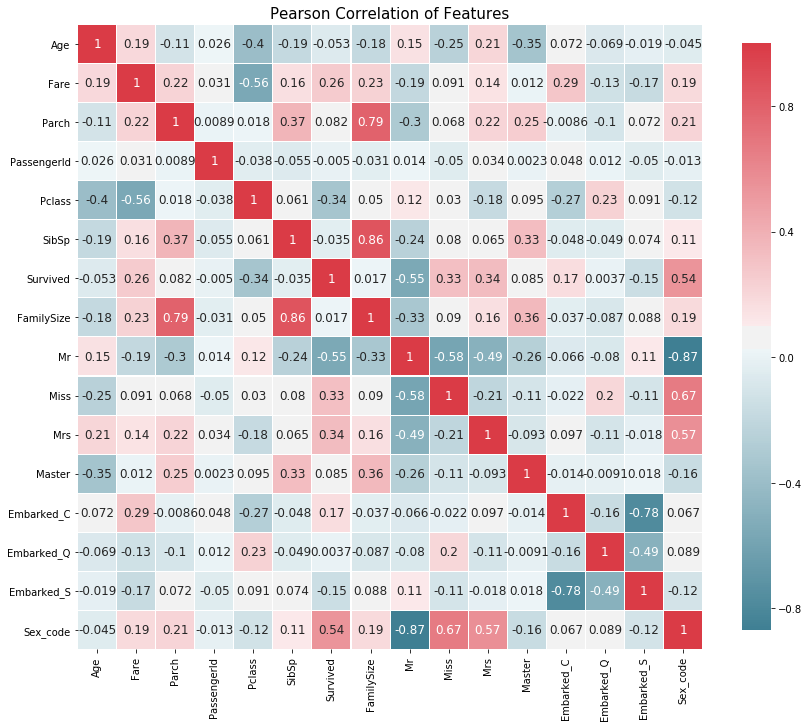

In [19]:
correlation_heatmap(datasetdummy)

In [20]:
datasetdummy.iloc[brk-2:brk+2, :].head()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,FamilySize,Mr,Miss,Mrs,Master,Embarked_C,Embarked_Q,Embarked_S,Sex_code
889,26.0,30.0000,0,890,1,0,1.0,0,1,0,0,0,1,0,0,0
890,32.0,7.7500,0,891,3,0,0.0,0,1,0,0,0,0,1,0,0
891,34.5,7.8292,0,892,3,0,NaN,0,1,0,0,0,0,1,0,0
892,47.0,7.0000,0,893,3,1,NaN,1,0,0,1,0,0,0,1,1


In [21]:
print('Train shape \t\t{}'.format(raw.shape))
print('Test shape \t\t{}'.format(rawt.shape))
# print('Combined Raw shape \t{}'.format(rawfull.shape))
print('Dummy shape \t\t{}'.format(datasetdummy.shape))

Train shape 		(891, 12)
Test shape 		(418, 11)
Dummy shape 		(1309, 16)


## Split training and test set and save

In [22]:
datatrain = datasetdummy.iloc[0:brk,:]
datatrain.shape

(891, 16)

In [23]:
datatest = datasetdummy.iloc[brk:,:]
datatest = datatest.drop(columns=['Survived'])
datatest.shape

(418, 15)

## Save output file

In [24]:
datatrain.to_csv('cl_train.csv', index=False)
datatest.to_csv('cl_test.csv', index=False)